# Welcome to the Polynomial Chaos Expansion (PCE) Example!

In this example, a PCE surrogate model is generated for the BatteryElectroChemEOD model. The surrogate is used to estimate time of event for a number of loading profiles. The result is compared to the actual time of event for the same loading profiles, which were generated by simulating the model.

PCE is a method by which the behavior of a model can be approximated by a polynomial. In this case the relationship between future loading and time of event. The result is a direct surrogate model that can be used to estimate time of event given a loading profile, without requiring the original model to be simulated. The resulting estimation is MUCH faster than simulating the model.

This functionality is especially useful in cases where you need to evaluate a large number of loading profiles in a short amount of time or with limited computational resources. For example, when you would like to optimize a loading profile. In that case, it would not make sense to have a state-transition model in the inner loop of the optimization, since the state transition model would be called many times. Instead, you can use a direct surrogate model to estimate time of event directly from the loading profile.

## `PolynomialChaosExpansion` Class Description

The [PolynomialChaosExpansion](https://nasa.github.io/progpy/api_ref/prog_models/DataModel.html#polynomialchaosexpansion) class inherits from the [DataModel](https://nasa.github.io/progpy/api_ref/prog_models/DataModel.html#datamodel) class. It's used to generate a polynomial chaos expansion from data or a model to learn the relationship between future inputs and time of event.

### Constructor

The `PolynomialChaosExpansion` class takes the following arguments in its constructor:

- `models`: A list of Polynomial chaos expansion models (one for each event).
- `times`: A list of times to use for the polynomial chaos expansion.
- `input_keys`: A list of input keys for the inputs.
- `event_keys`: An optional list of event keys for the events. If not provided, they will be generated as e0, e1, e2, etc.

### Methods

The class has the following methods:

1. `__init__(self, models, times, input_keys, **kwargs)`: Initializes the `PolynomialChaosExpansion` object.

2. `time_of_event(self, x, future_loading_eqn, **kwargs)`: Predicts the time of event for future inputs. Returns a dictionary where keys are event keys and values are results from the polynomial chaos expansion models.

3. [from_data](https://nasa.github.io/progpy/api_ref/prog_models/DataModel.html#prog_models.data_models.PolynomialChaosExpansion.from_data)`(cls, times, inputs, time_of_event, input_keys, **kwargs)`: Class method that creates a `PolynomialChaosExpansion` object from data. It trains the polynomial chaos expansion using the provided inputs and time of event data. Returns a `PolynomialChaosExpansion` object.

4. [from_model](https://nasa.github.io/progpy/api_ref/prog_models/DataModel.html#prog_models.data_models.PolynomialChaosExpansion.from_model)`(cls, m, x, input_dists, times, **kwargs)`: Class method that creates a `PolynomialChaosExpansion` object from a model. It trains the polynomial chaos expansion using the provided model and initial state. Returns a `PolynomialChaosExpansion` object.
"""


### Importing Modules

In [9]:
import chaospy as cp
import matplotlib.pyplot as plt
import numpy as np
from progpy.models import BatteryElectroChemEOD
from progpy.data_models import PCE
import scipy as sp

First, let's define some constants that we'll use for the remainder of the example!

In [10]:
# Time step used in simulation
DT = 0.5 

# The number of samples to used in the PCE
# Larger gives a better approximation, but takes longer to generate
N_SAMPLES = 100

# The distribution of the input current
# This defines the expected values for the input
# In this case we're saying that the input current can be anything between 3-8 amps
# With a uniform distribution (i.e., no value in that range is more likely than any other)
INPUT_CURRENT_DIST = cp.Uniform(3, 8)

Note: These discharge rates are VERY high. This is only for demonstration purposes. The high discharge rate will accelerate the degradation of the battery, which will cause the example to run faster.

Now, let's first define the base model that we're creating a surrogate for and the model's initial state.

In [11]:
m = BatteryElectroChemEOD(process_noise = 0)
x0 = m.initialize()  # Initial State

Next, we'll build the surrogate model from the base model. To build the model, we pass in the distributions of possible values for each input. The surrogate model will be trained using the base model and the initial state.

We also provide the `max_time`. This is the maximum time that the surrogate will be used for. We don't expect any battery to last more than 4000 seconds given the high discharge curves we're passing in.

In [12]:
m_surrogate = PCE.from_model(m, 
    x0,                         # Model State
    {'i': INPUT_CURRENT_DIST},  # Distribution of inputs
    dt=DT, 
    times = [i*1000 for i in range(5)],
    N = N_SAMPLES)

The result (m_surrogate) is a model that can be used to VERY quickly estimate time_of_event for a new loading profile!

Note: this is only valid for the initial state (`x0`) of the battery. To train for another state pass in the parameter `x` (type `StateContainer`). 

E.g. `m_surrogate = PCE.from_model(m, SOME_OTHER_STATE, ...)`

____

Now, let's test the surrogate! We can do this by generating various loading profiles and comparing the surrogate's estimate of time of event to the actual time of event (from simulation).

We'll use Scipy's Interpolation Sub-Package to create 

In [20]:
N_TEST_CASES = 25 # The number of loading profiles to test

# some containers for the results
surrogate_results = np.empty(N_TEST_CASES, dtype=np.float64)
gt_results = np.empty(N_TEST_CASES, dtype=np.float64)

# Future loading- interpolates values from randomly sampled values
def future_loading(t, x=None):
    return m.InputContainer(interpolator(t)[np.newaxis].T)

Finally, let's create the `TEST_SAMPLES` and start filling out the results to compare the surrogate's estimate of time of event to the actual time of event (from simulation).

In [18]:
TEST_SAMPLES = m_surrogate.parameters['J'].sample(size=N_TEST_CASES, rule='latin_hypercube')

Now, let's create the various types of loading profiles that we'll use to test the surrogate and begin simulating the base model and the PCE model to get the actual time of event for each loading profile.

In [21]:
for i in range(N_TEST_CASES):
    # Generate a new loading profile
    interpolator = sp.interpolate.interp1d(m_surrogate.parameters['times'], TEST_SAMPLES[:, i])
    # Future Loading Function- interpolates values from randomly sampled values

    # Estimate time of event from ground truth (original model) and surrogate
    gt_results[i] = m.time_of_event(x0, future_loading, dt = DT)['EOD']
    surrogate_results[i] = m_surrogate.time_of_event(x0, future_loading)['EOD']


Finally, we can plot the results!

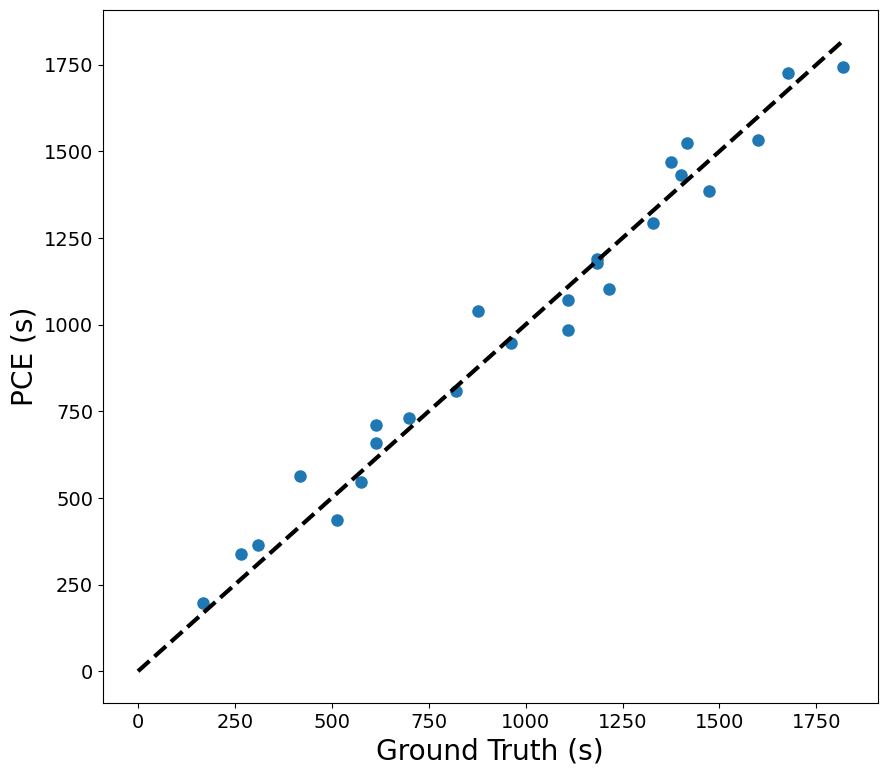

In [16]:
plt.scatter(gt_results, surrogate_results)
max_val = max(max(gt_results), max(surrogate_results))
plt.plot([0, max_val], [0, max_val], 'k--')
plt.xlabel("Ground Truth (s)")
plt.ylabel("PCE (s)")
plt.show()

The results are plotted as a scatter plot where the x-axis represents the ground truth results (actual time of event from the original model) and the y-axis represents the PCE surrogate results. The line $y=x$ is also plotted for reference. The scatter plot gives a visual comparison of the performance of the PCE surrogate model against the original model.

__Please note that the results are not shown in the script, and the accuracy of the surrogate model would depend on the specifics of the run, including the number of samples used in the PCE, the actual loading profiles, etc. Typically, the approximation of the surrogate model would improve with more samples.__